In [2]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv

load_dotenv()

True

In [3]:
import pandas as pd
from lib.json import read_from_json_file

inputs = pd.DataFrame(read_from_json_file("inputs"))

inputs.head()

,/r/IsA,/r/DefinedAs,/r/DistinctFrom,/r/PartOf,/r/HasA,/r/MadeOf,/r/UsedFor,/r/Causes,/r/CapableOf
0,"[/c/en/pituitary, /c/en/gland]","[/c/en/master_bedroom, /c/en/main_bedroom_in_d...","[/c/en/cake, /c/en/doughnut]","[/c/en/bidar, /c/en/karnataka]","[/c/en/bicycles, /c/en/spokes]","[/c/en/soccer_ball, /c/en/leather]","[/c/en/cooking_meal, /c/en/health]","[/c/en/climbing, /c/en/improve_one's_vista]","[/c/en/robber, /c/en/case_job]"
1,"[/c/en/inside_carseat, /c/en/metal_framework]","[/c/en/uncle, /c/en/husband_of_aunt]","[/c/en/u.s, /c/en/state]","[/c/en/kaifeng, /c/en/henan]","[/c/en/lpkb, /c/en/no_shares_in_esb]","[/c/en/duvet, /c/en/cotton]","[/c/en/toothbrush_head, /c/en/removing_plaque]","[/c/en/taking_finals, /c/en/finishing_class]","[/c/en/teenagers, /c/en/play_lacrosse]"
2,"[/c/en/mitochondria, /c/en/energy_producing_co...","[/c/en/matrimony, /c/en/state_of_wedlock]","[/c/en/story, /c/en/real]","[/c/en/aoa, /c/en/american_samoa]","[/c/en/tenor, /c/en/extremely_low_singing_range]","[/c/en/t_shirt, /c/en/cloth_and_fabric]","[/c/en/stage, /c/en/performances]","[/c/en/deciding_criminal_s_fate, /c/en/sadness]","[/c/en/people, /c/en/sleep_inside_tents]"
3,"[/c/en/odyssey, /c/en/epic_poem]","[/c/en/silicone, /c/en/substrate_for_most_micr...","[/c/en/father, /c/en/mom]","[/c/en/guilt, /c/en/crime]","[/c/en/sometimes_people, /c/en/make_sacrifices]","[/c/en/hydrogen, /c/en/subatomic_particles]","[/c/en/automatic_gate, /c/en/keep_pets_from_st...","[/c/en/drinking_alcohol, /c/en/bad_breath]","[/c/en/trainer, /c/en/page_veterinarian]"
4,[/c/en/waterton_glacier_international_peace_pa...,"[/c/en/isn't, /c/en/contraction_of_not]","[/c/en/future, /c/en/pasta]","[/c/en/sclera, /c/en/eye]","[/c/en/owls, /c/en/eyes]","[/c/en/chopsticks, /c/en/bamboo]","[/c/en/forest, /c/en/cutting_down_and_making_p...","[/c/en/bringing_suit, /c/en/ruling]","[/c/en/cook, /c/en/wash_vegetable]"


In [4]:
from lib.relations import USED_RELATIONS


taxonomic_relations, mereological_relations, functional_relations = USED_RELATIONS[0:3], USED_RELATIONS[3:6], USED_RELATIONS[6:9]

taxonomic_relations, mereological_relations, functional_relations

(['/r/IsA', '/r/DefinedAs', '/r/DistinctFrom'],
 ['/r/PartOf', '/r/HasA', '/r/MadeOf'],
 ['/r/UsedFor', '/r/Causes', '/r/CapableOf'])

In [5]:
import random
import pandas as pd
from lib.formatting import convert_conceptnet_uri

# Step 1: Collect all concept pairs from all relation categories
pairs = []

for relation in taxonomic_relations:
    for row in inputs[relation]:
        pairs.append((convert_conceptnet_uri(row[0]), convert_conceptnet_uri(row[1])))

for relation in mereological_relations:
    for row in inputs[relation]:
        pairs.append((convert_conceptnet_uri(row[0]), convert_conceptnet_uri(row[1])))

for relation in functional_relations:
    for row in inputs[relation]:
        pairs.append((convert_conceptnet_uri(row[0]), convert_conceptnet_uri(row[1])))

# Step 2: Shuffle the pairs randomly
random.shuffle(pairs)

# Step 3: Evenly split and assign random labels
num_labels = 3
labels = ["taxonomic", "mereological", "functional"]
n = len(pairs) // num_labels

examples = []
for i, label in enumerate(labels):
    start = i * n
    end = (i + 1) * n if i < num_labels - 1 else len(pairs)  # ensure full coverage
    for pair in pairs[start:end]:
        examples.append((pair[0], pair[1], label))

# Step 4: Create dataframe
examples_df = pd.DataFrame(examples, columns=["concept1", "concept2", "relation"])
examples_df = examples_df.sample(frac=1).reset_index(drop=True)  # optional: shuffle again

examples_df.head()


,concept1,concept2,relation
0,people,play soccer in back yard,taxonomic
1,baja california,mexicali,mereological
2,gulf of mexico,shrimp,mereological
3,john safran,australian documentarian and media personality...,mereological
4,clinics,multiple of clinic,functional


In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from lib.bert import get_cls_embedding

X = []
y = []

for c1, c2, relation in tqdm(examples, desc="Encoding examples"):
    emb = get_cls_embedding(c1, c2)
    X.append(emb)
    y.append(relation)

X = np.array(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Encoding examples: 100%|██████████| 3600/3600 [02:40<00:00, 22.39it/s]


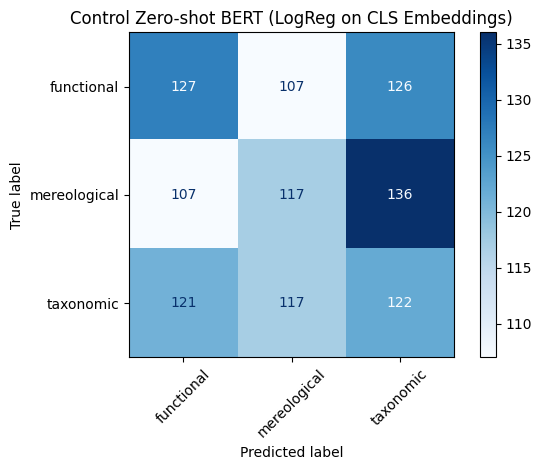

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Control Zero-shot BERT (LogReg on CLS Embeddings)")
plt.tight_layout()
plt.show()

/Users/colegawin/Documents/ling 486 final project/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/colegawin/Documents/ling 486 final project/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


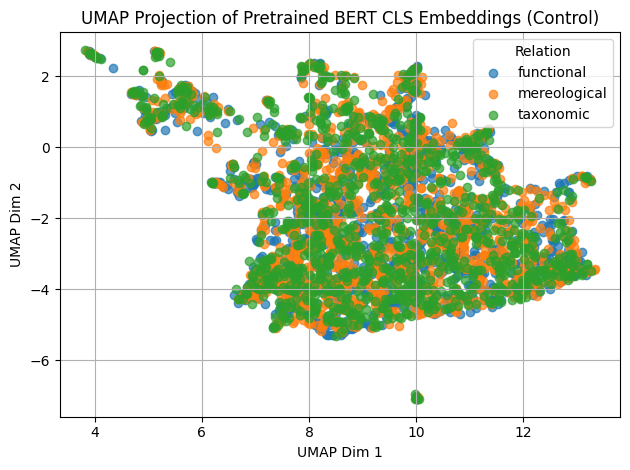

In [8]:
import umap
import matplotlib.pyplot as plt

# Create a UMAP object
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# Use the same label encoder from before
relation_names = label_encoder.inverse_transform(sorted(set(y_encoded)))
colors = ["blue", "orange", "green"]  # Adjust if you have more classes

for i, rel in enumerate(relation_names):
    idx = y_encoded == label_encoder.transform([rel])[0]
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], label=rel, alpha=0.7)

plt.title("UMAP Projection of Pretrained BERT CLS Embeddings (Control)")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Relation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, y_encoded, metric='cosine')

print("Silhouette score:", score)

Silhouette score: -0.009495953
